In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
answers = pd.read_csv('./data/Answer.csv')
survey_2020 = pd.read_csv('./data/2020-survey.csv')
correct_columns = [1, 2, 3, 5, 6, 7, 8, 9, 13, 17, 18, 19, 30, 32, 33, 34, 93, 97, 99, 100, 117, 118]

In [3]:
unused_questions_removed = survey_2020.columns[survey_2020.columns.str.startswith('q')]
survey_2020 = survey_2020[unused_questions_removed]


## Filter out unrelevant questions

In [4]:
answers = answers[answers['QuestionID'].isin(correct_columns)]

## Create survey DataFrame

We want a data frame where each row will represent one users answers to one survey. We create a empty DataFrame and fill it out with one row for each unique UserID found in the answers table.

In [5]:
surveys = pd.DataFrame(columns=['q1', 'q2', 'q3', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19', 'q30', 'q32', 'q33', 'q34', 'q93', 'q97', 'q99', 'q100', 'q117', 'q118' 'Year'])
user_ids = answers['UserID'].unique()
surveys['UserID'] = user_ids

In order to fill out the survey DataFrame we have to iterate through each row in the answers table and set the values in the corresponding row in surveys.

In [6]:
for answer in answers.iterrows():
    user_id = answer[1][2]
    question_id = 'q' + str(answer[1][3])
    answer_text = answer[1][0]
    year = answer[1][1]
    surveys.at[user_id - 1, question_id] = answer_text
    surveys.at[user_id - 1, 'Year'] = year
        
    

Some questions are very similar but does only exists in some years, we choose to combine these questions.

In [7]:
surveys['q17'] = surveys['q17'].combine_first(surveys['q97'])
surveys['q18'] = surveys['q18'].combine_first(surveys['q99'])
surveys['q19'] = surveys['q19'].combine_first(surveys['q100'])

surveys = surveys.drop(['q97', 'q99', 'q100'], axis = 1)


## Pre-processing


## Age
Some age values are negative, therefore those entries will be changed to positive. Also, there are some unrealistic ages, those will be removed.

In [8]:
age_values = surveys['q1'].value_counts()
age_values

30     250
29     229
32     227
31     223
28     220
      ... 
3        1
17       1
-29      1
8        1
70       1
Name: q1, Length: 65, dtype: int64

In [9]:
surveys['q1'] = surveys['q1'].str.replace('-','')
surveys['q1'] = surveys['q1'].astype(int)

In [10]:
surveys['q1'] = surveys[surveys['q1'] > 16]
surveys['q1'] = surveys[surveys['q1'] < 100]
age_values = surveys['q1'].value_counts()
age_values
                        

30.0    250
29.0    230
32.0    227
31.0    223
28.0    220
34.0    202
35.0    201
33.0    201
27.0    197
26.0    194
37.0    184
38.0    160
36.0    147
25.0    147
39.0    137
24.0    128
40.0    122
23.0    107
42.0    100
41.0     88
43.0     82
22.0     74
45.0     74
44.0     68
46.0     58
21.0     39
47.0     38
49.0     36
50.0     30
48.0     29
51.0     22
55.0     22
19.0     20
52.0     17
54.0     17
20.0     17
53.0     15
57.0     14
56.0     13
18.0      9
61.0      7
59.0      6
58.0      5
60.0      5
63.0      5
62.0      3
64.0      3
65.0      3
66.0      2
67.0      2
72.0      1
74.0      1
17.0      1
70.0      1
99.0      1
Name: q1, dtype: int64

## Gender
The surveys respondents have answered this question in free text format, there fore we had to change many entries to 'other' and group 'Male' and 'male' etc.

In [11]:
gender_values = surveys['q2'].value_counts()
print(gender_values)

surveys['q2'] = surveys['q2'].str.lower()
gender_values = surveys['q2'].value_counts()
gender_values

Male                 2830
Female                914
male                  212
female                110
-1                     24
                     ... 
non binary              1
Unicorn                 1
\-                      1
trans woman             1
She/her/they/them       1
Name: q2, Length: 101, dtype: int64


male                           3043
female                         1024
-1                               24
non-binary                        9
nonbinary                         9
                               ... 
uhhhhhhhhh fem genderqueer?       1
transgender                       1
43                                1
bigender                          1
sometimes                         1
Name: q2, Length: 87, dtype: int64

In [12]:
surveys['q2'] = np.where(((surveys.q2 != 'male') & (surveys.q2 != 'female')),'other',surveys.q2)
gender_values = surveys['q2'].value_counts()
gender_values

male      3043
female    1024
other      151
Name: q2, dtype: int64

## Country
There were entries for 'Unitade States' and 'United States of America'. We grouped them together.

In [13]:
country_values = surveys['q3'].value_counts()
print(country_values)
surveys['q3'] = np.where((surveys.q3 == 'United States of America'),'United States',surveys.q3)
country_values = surveys['q3'].value_counts()
country_values

United States of America    1853
United States                751
United Kingdom               482
Canada                       199
Germany                      136
                            ... 
Ethiopia                       1
Iran                           1
Vietnam                        1
Belarus                        1
Saudi Arabia                   1
Name: q3, Length: 81, dtype: int64


United States     2604
United Kingdom     482
Canada             199
Germany            136
Netherlands         98
                  ... 
Vietnam              1
Ethiopia             1
Iran                 1
Belarus              1
Saudi Arabia         1
Name: q3, Length: 80, dtype: int64

## Mental health disorder
It seems like different surveys used the answer 'Possibly' and 'Maybe' as the same answer so we grouped them together.


In [14]:
q33_values = surveys['q33'].value_counts()
print(q33_values)
surveys['q33'] = np.where((surveys.q33 == 'Possibly'),'Maybe',surveys.q33)
country_values = surveys['q33'].value_counts()
country_values

Yes           1237
No             969
Maybe          327
Possibly       301
Don't Know     124
Name: q33, dtype: int64


Yes           1237
No             969
Maybe          628
Don't Know     124
Name: q33, dtype: int64

## Pre process 2020 survey
In order to concat the 2020 survey to our surveys DataFrame we have to do some pre processing.

In [15]:
survey_2020 = survey_2020[['q1', 'q2', 'q3', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19', 'q30', 'q32', 'q33', 'q34']]
survey_2020.sample(20)


,q1,q2,q3,q5,q6,q7,q8,q9,q13,q17,q18,q19,q30,q32,q33,q34
56,58,male,United States of America,0,No,1,500-1000,0.0,1.0,Somewhat easy,No,No,8,Yes,No,NaN
126,27,M,Colombia,0,No,1,More than 1000,0.0,0.0,I don't know,No,No,1,Possibly,Possibly,NaN
119,32,Female,India,0,No,0,More than 1000,0.0,1.0,Neither easy nor difficult,Maybe,Yes,8,No,Don't Know,NaN
12,40,Female,Canada,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,8,No,No,NaN
168,39,Male,United States of America,0,Yes,1,26-100,1.0,1.0,Very easy,Yes,Yes,9,Yes,Yes,Yes
53,34,male,Australia,0,I don't know,0,100-500,0.0,1.0,Somewhat easy,Maybe,Maybe,5,Don't Know,Don't Know,NaN
84,33,Female,United States of America,0,No,0,More than 1000,0.0,1.0,I don't know,Maybe,Maybe,5,No,Possibly,NaN
93,23,Female,Serbia,0,No,0,100-500,0.0,1.0,Neither easy nor difficult,Yes,Yes,8,No,Don't Know,NaN
63,34,Male,South Africa,0,Yes,1,6-25,1.0,1.0,Difficult,Yes,No,10,Yes,Yes,Yes
80,33,female,Canada,0,No,0,More than 1000,0.0,1.0,Somewhat difficult,No,Maybe,4,No,Possibly,NaN


## Plots

<AxesSubplot:xlabel='q2', ylabel='count'>

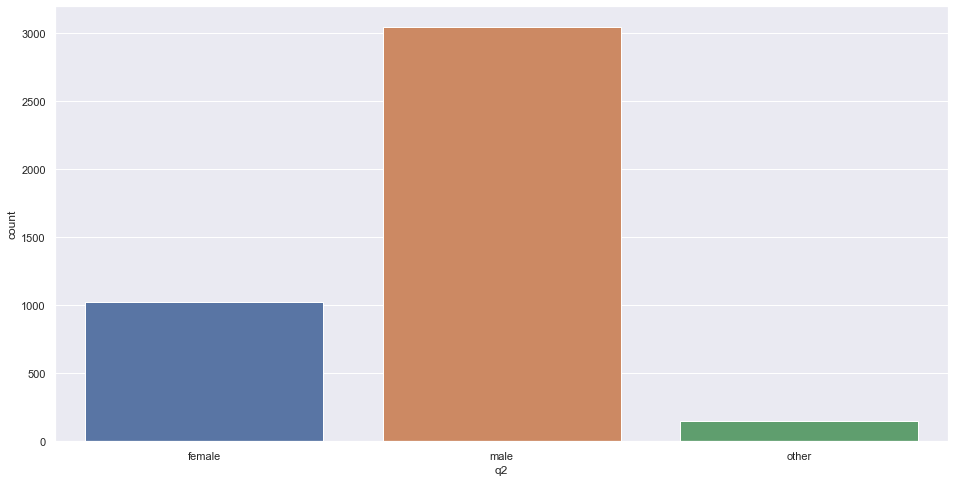

In [24]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.countplot(x='q2', data=surveys)

<AxesSubplot:xlabel='q33', ylabel='count'>

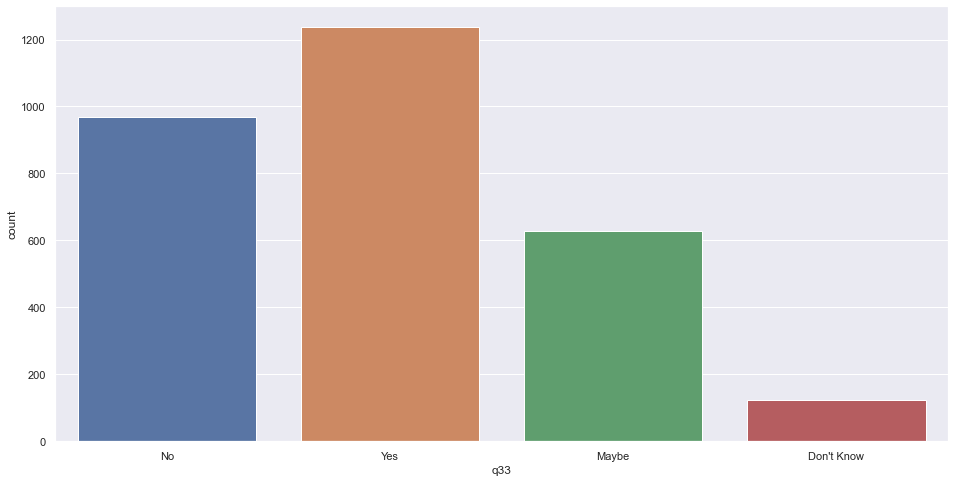

In [25]:
sns.countplot(x='q33', data=surveys)

<AxesSubplot:xlabel='q8', ylabel='count'>

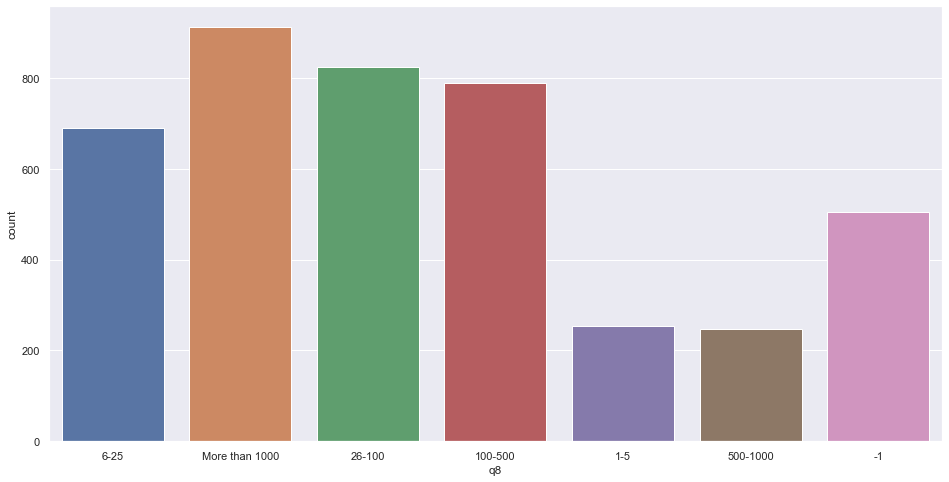

In [26]:
sns.countplot(x='q8', data=surveys)